## 1. Importación de Bibliotecas

**¿Por qué?**: Primero, importaremos todas las bibliotecas necesarias para realizar el análisis. Estas incluyen herramientas para el manejo de datos (`pandas`, `numpy`), modelos de regresión (`scikit-learn`, `xgboost`), y herramientas para la visualización y análisis estadístico (`matplotlib`, `seaborn`, `scipy`, `baycomp`).


In [ ]:
!pip install baycomp
!pip install scikit-posthocs
!pip install catboost

  Preparing metadata (setup.py) ... done
  Created wheel for baycomp: filename=baycomp-1.0.3-py3-none-any.whl size=18029 sha256=a8b783138c52baa3c26111605ac44c87e504f401e17a4de146a85ded1a4085e4
  Stored in directory: /root/.cache/pip/wheels/8a/aa/61/8f1e79a2be629eaa2a72b495c56bb667568dac7c33f4e4c408
Successfully built baycomp
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.3 MB/s eta 0:00:00


In [ ]:
# Importar bibliotecas
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer

from catboost import CatBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb


import matplotlib.pyplot as plt
import scikit_posthocs as sp
import baycomp

from tqdm import tqdm

## 2. Cargar el Dataset y Preparar los Datos

**¿Por qué?**: En esta sección, cargamos el dataset de **California Housing** usando `fetch_california_housing` de `scikit-learn`. Luego, dividimos el dataset en conjuntos de entrenamiento y prueba para que podamos entrenar los modelos y evaluar su rendimiento de manera efectiva.

In [ ]:
Datos = pd.read_csv("train.csv")
Datos_venta = Datos[["HomePlanet", "Destination", "VIP", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Transported", "Age","CryoSleep"]]
# Limpiar datos
Datos_venta['RoomService'] = Datos_venta['RoomService'].fillna(0).astype(int)
Datos_venta['FoodCourt'] = Datos_venta['FoodCourt'].fillna(0).astype(int)
Datos_venta['ShoppingMall'] = Datos_venta['ShoppingMall'].fillna(0).astype(int)
Datos_venta['Spa'] = Datos_venta['Spa'].fillna(0).astype(int)
Datos_venta['VRDeck'] = Datos_venta['VRDeck'].fillna(0).astype(int)
Datos_venta['VIP'] = Datos_venta['VIP'].fillna("False").astype(str)
Datos_venta['CryoSleep'] = Datos_venta['CryoSleep'].fillna("False").astype(str)
Datos_venta['Destination'] = Datos_venta['Destination'].fillna(Datos_venta['Destination'].mode()[0]).astype(str)
Datos_venta['HomePlanet'].fillna('Earth', inplace=True)
Datos_venta['HomePlanet'] = Datos_venta['HomePlanet'].replace('Europa', 'Earth')
Datos_venta['Age'] = Datos_venta['Age'].fillna(Datos_venta['Age'].mode()[0]).astype(int)

# Variables independientes y dependientes
X_datos_venta = Datos_venta.drop(['Transported'], axis=1)
Y_datos_venta = Datos_venta['Transported']

# One Hot Encoding
X_datos_venta_encoded = pd.get_dummies(X_datos_venta, columns=['VIP'], dtype=int, drop_first=True)
X_datos_venta_encoded = pd.get_dummies(X_datos_venta_encoded, columns=['CryoSleep'], dtype=int, drop_first=True)
X_datos_venta_encoded = pd.get_dummies(X_datos_venta_encoded, columns=['HomePlanet'], dtype=int, drop_first=True)
X_datos_venta_encoded = pd.get_dummies(X_datos_venta_encoded, columns=['Destination'], dtype=int, drop_first=True)

X=X_datos_venta_encoded
y=Y_datos_venta

nan_cols = X.isnull().sum()
nan_cols.loc[nan_cols != 0]

x_num = X.select_dtypes(include=["int64","float64"])
x_num.shape
# Separar datos en train y test
#x_train, x_test, y_train, y_test = train_test_split(X_datos_venta_encoded, Y_datos_venta, test_size=0.2)

<ipython-input-4-9e9591ab614a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Datos_venta['RoomService'] = Datos_venta['RoomService'].fillna(0).astype(int)
<ipython-input-4-9e9591ab614a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Datos_venta['FoodCourt'] = Datos_venta['FoodCourt'].fillna(0).astype(int)
<ipython-input-4-9e9591ab614a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

(8693, 11)

## 3. Definición, Entrenamiento y Evaluación de los Regresores

En esta sección, definimos 11 modelos de regresión diferentes, los entrenamos y luego los evaluamos utilizando la validación cruzada con 10 particiones (10-fold cross-validation) para calcular diversas métricas de desempeño.

In [ ]:
# Definir los clasificadores
models = {
    'CatBoostClassifier': CatBoostClassifier(verbose=0),
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'SVC':SVC(),
    'LogisticRegression': LogisticRegression()
}

# Definir las métricas para la validación cruzada
scoring = {
    'Accuracy': make_scorer(accuracy_score),
    'Precision': make_scorer(precision_score, average='weighted'),
    'Recall': make_scorer(recall_score, average='weighted'),
    'F1': make_scorer(f1_score, average='weighted')
}

# Evaluar los regresores utilizando 5-fold cross-validation y guardar los resultados por métrica
results = {}
for name, model in tqdm(models.items(), desc="Evaluando Modelos"):
    results[name] = {}
    for metric_name, metric in tqdm(scoring.items(), desc=f"Evaluando métricas para {name}", leave=False):
        scores = cross_val_score(model, X, y, cv=5, scoring=metric)
        results[name][metric_name] = scores  # Guardar los 5 resultados individuales

# Convertir los resultados a un DataFrame para cada métrica
accuracy_df = pd.DataFrame({model: results[model]['Accuracy'] for model in models.keys()})
precision_df = pd.DataFrame({model: results[model]['Precision'] for model in models.keys()})
recall_df = pd.DataFrame({model: results[model]['Recall'] for model in models.keys()})
f1_df = pd.DataFrame({model: results[model]['F1'] for model in models.keys()})

Evaluando Modelos:  40%|████      | 2/5 [01:45<02:20, 46.86s/it]
Evaluando métricas para GradientBoostingClassifier:   0%|          | 0/4 [00:00<?, ?it/s]
Evaluando métricas para GradientBoostingClassifier:  25%|██▌       | 1/4 [00:03<00:11,  3.71s/it]
Evaluando métricas para GradientBoostingClassifier:  50%|█████     | 2/4 [00:07<00:07,  3.75s/it]
Evaluando métricas para GradientBoostingClassifier:  75%|███████▌  | 3/4 [00:12<00:04,  4.16s/it]
Evaluando métricas para GradientBoostingClassifier: 100%|██████████| 4/4 [00:16<00:00,  4.07s/it]
Evaluando métricas para LogisticRegression:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternat

In [ ]:
# Imprimir cada DataFrame por métrica

# Resultados para accuracy_df
print("DataFrame de accuracy (10 resultados por modelo):")
print(accuracy_df)
print("\n")

# Resultados para precision
print("DataFrame de precision (10 resultados por modelo):")
print(precision_df)
print("\n")

# Resultados para recall
print("DataFrame de recall (10 resultados por modelo):")
print(recall_df)
print("\n")

# Resultados para f1
print("DataFrame de f1 (10 resultados por modelo):")
print(f1_df)
print("\n")

DataFrame de accuracy (10 resultados por modelo):
   CatBoostClassifier  RandomForestClassifier  GradientBoostingClassifier  \
0            0.792984                0.780334                    0.782634   
1            0.783784                0.778033                    0.779758   
2            0.794135                0.786084                    0.780909   
3            0.803797                0.797468                    0.804373   
4            0.799770                0.796893                    0.799770   

        SVC  LogisticRegression  
0  0.769983            0.782634  
1  0.771708            0.782059  
2  0.790109            0.780909  
3  0.800345            0.780783  
4  0.798619            0.788838  


DataFrame de precision (10 resultados por modelo):
   CatBoostClassifier  RandomForestClassifier  GradientBoostingClassifier  \
0            0.795470                0.785174                    0.788862   
1            0.787873                0.781117                    0.785819   

## 4. Análisis y Visualización de Métricas Individuales

En esta sección, analizaremos y visualizaremos cada métrica por separado para proporcionar una evaluación clara y comprensible del rendimiento de los diferentes modelos.

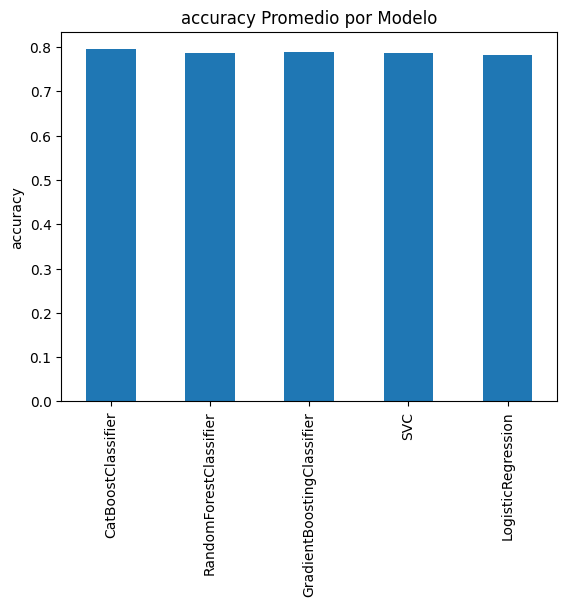

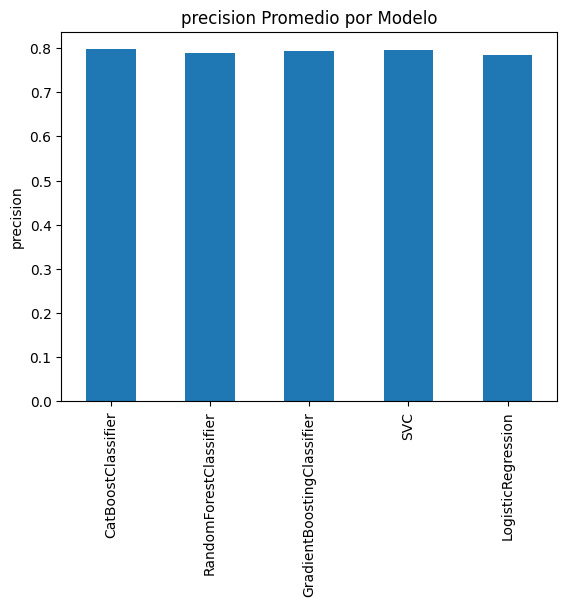

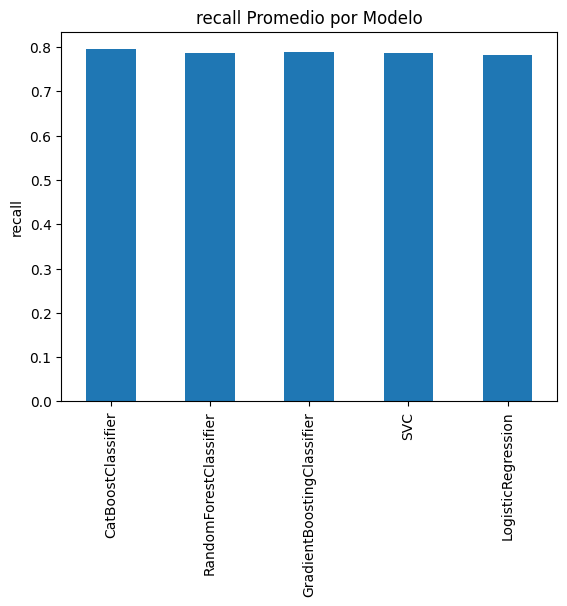

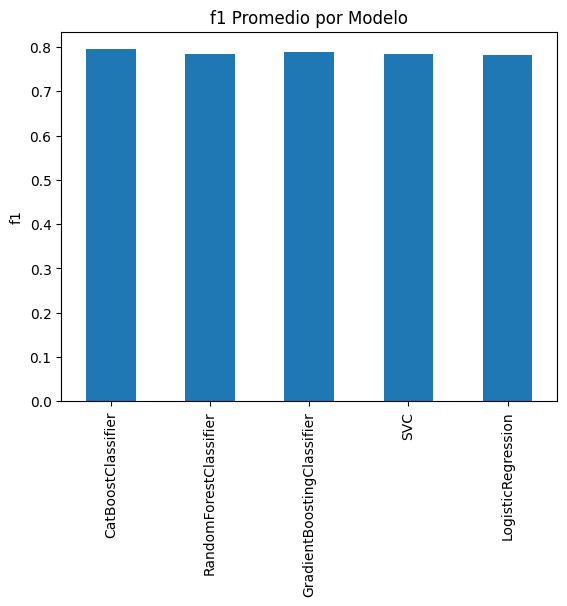

In [ ]:
# Calcular promedios
accuracy_mean = accuracy_df.mean()
precision_mean = precision_df.mean()
recall_mean = recall_df.mean()
f1_mean = f1_df.mean()

# Visualizar los resultados
accuracy_mean.plot(kind='bar', title='accuracy Promedio por Modelo')
plt.ylabel('accuracy')
plt.show()

precision_mean.plot(kind='bar', title='precision Promedio por Modelo')
plt.ylabel('precision')
plt.show()

recall_mean.plot(kind='bar', title='recall Promedio por Modelo')
plt.ylabel('recall')
plt.show()

f1_mean.plot(kind='bar', title='f1 Promedio por Modelo')
plt.ylabel('f1')
plt.show()



## 5. Análisis de Diferencias Críticas (Critical Difference)

En esta sección, utilizaremos los resultados de las evaluaciones de los modelos para generar un diagrama de diferencias críticas (Critical Difference Diagram), que nos permitirá visualizar cuáles modelos son significativamente diferentes entre sí.

CatBoostClassifier            4.7
RandomForestClassifier        2.2
GradientBoostingClassifier    3.5
SVC                           2.4
LogisticRegression            2.2
dtype: float64


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/scikit_posthocs/_plotting.py:498: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  key=lambda x: ranks[list(x)].min()
/usr/local/lib/python3.10/dist-packages/scikit_posthocs/_plotting.py:518: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [ranks[i] for i in bar],


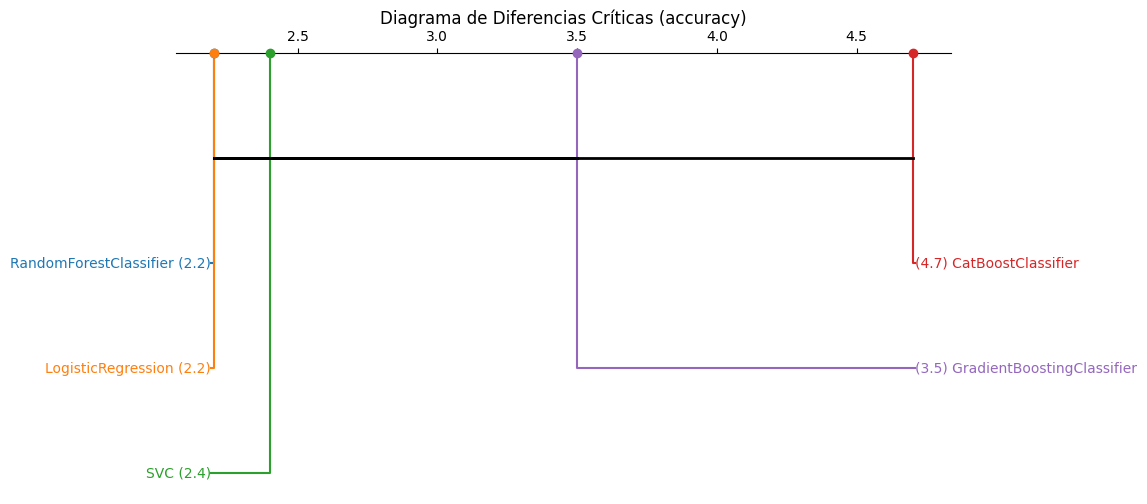

CatBoostClassifier            4.2
RandomForestClassifier        1.6
GradientBoostingClassifier    3.4
SVC                           4.0
LogisticRegression            1.8
dtype: float64


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/scikit_posthocs/_plotting.py:498: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  key=lambda x: ranks[list(x)].min()
/usr/local/lib/python3.10/dist-packages/scikit_posthocs/_plotting.py:518: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [ranks[i] for i in bar],


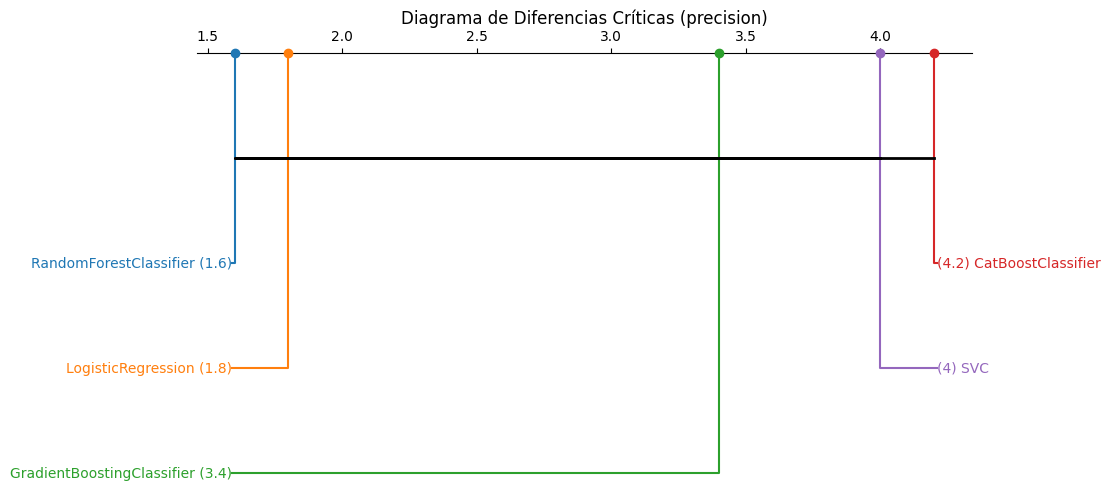

CatBoostClassifier            4.7
RandomForestClassifier        2.6
GradientBoostingClassifier    3.3
SVC                           2.3
LogisticRegression            2.1
dtype: float64


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/scikit_posthocs/_plotting.py:498: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  key=lambda x: ranks[list(x)].min()
/usr/local/lib/python3.10/dist-packages/scikit_posthocs/_plotting.py:518: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [ranks[i] for i in bar],


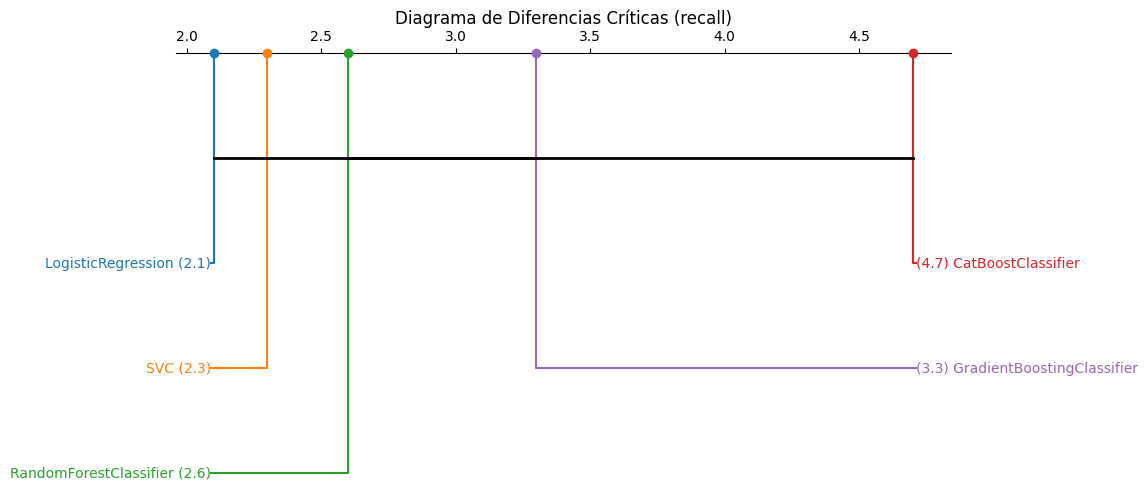

CatBoostClassifier            4.8
RandomForestClassifier        2.0
GradientBoostingClassifier    3.4
SVC                           2.4
LogisticRegression            2.4
dtype: float64


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/scikit_posthocs/_plotting.py:498: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  key=lambda x: ranks[list(x)].min()
/usr/local/lib/python3.10/dist-packages/scikit_posthocs/_plotting.py:518: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [ranks[i] for i in bar],


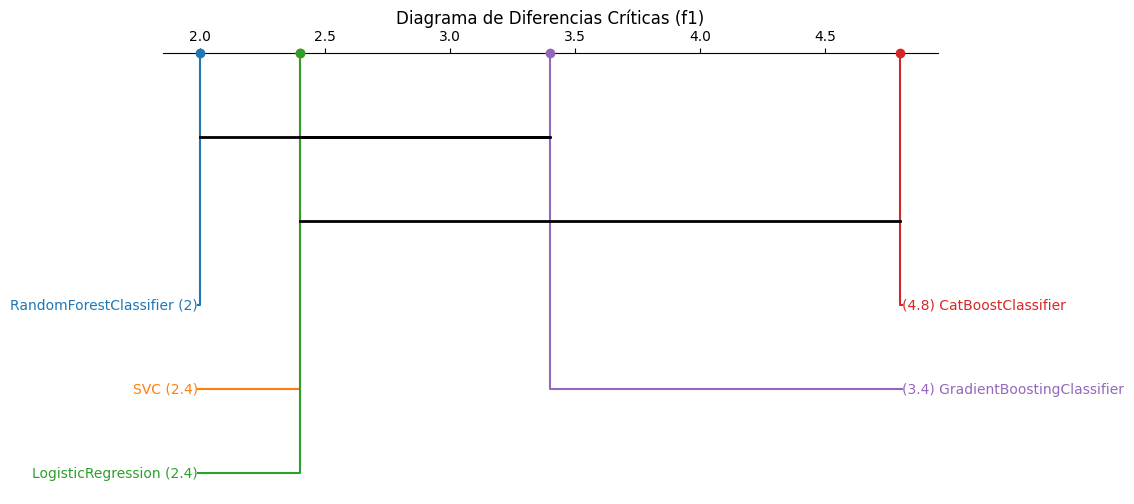

In [ ]:
# Function to calculate and visualize critical differences using scikit-posthocs
def calcular_diferencias_criticas(df, metric_name):
    try:
        # Calculate ranks of the models
        avg_rank = df.rank(axis=1).mean(axis=0)
        print(avg_rank)

        # Perform the Nemenyi post-hoc test
        cd_result = sp.posthoc_nemenyi_friedman(df.values)

        # Plot the critical difference diagram
        plt.figure(figsize=(10, 6), dpi=100)
        plt.title(f'Diagrama de Diferencias Críticas ({metric_name})')
        sp.critical_difference_diagram(avg_rank, cd_result)
        plt.show()

    except ValueError as e:
        print(f"Error al calcular diferencias críticas para {metric_name}: {e}")

# Calculate and plot critical differences for each metric
calcular_diferencias_criticas(accuracy_df, 'accuracy')
calcular_diferencias_criticas(precision_df, 'precision')
calcular_diferencias_criticas(recall_df, 'recall')
calcular_diferencias_criticas(f1_df, 'f1')

## 6. Comparación Bayesiana de Todos los Regresores

En esta sección, realizaremos una comparación bayesiana entre todos los pares de regresores. Esta comparación nos permitirá evaluar, desde una perspectiva probabilística, si un modelo es mejor, peor, o equivalente a otro modelo en términos de las métricas que definimos.


Comparación bayesiana entre CatBoostClassifier y RandomForestClassifier en accuracy: (0.15056278200149711, 0.848390007792194, 0.001047210206308935)


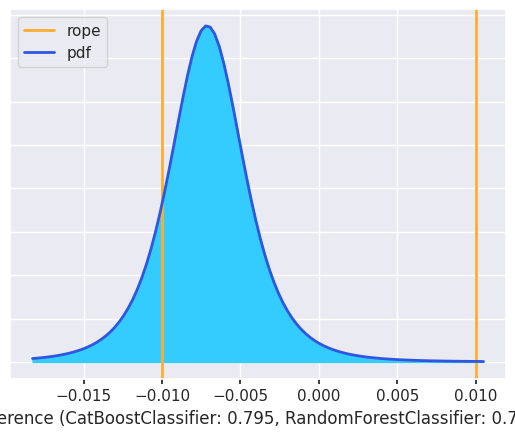

Comparación bayesiana entre CatBoostClassifier y GradientBoostingClassifier en accuracy: (0.16476045202272702, 0.8249947391778114, 0.010244808799461547)


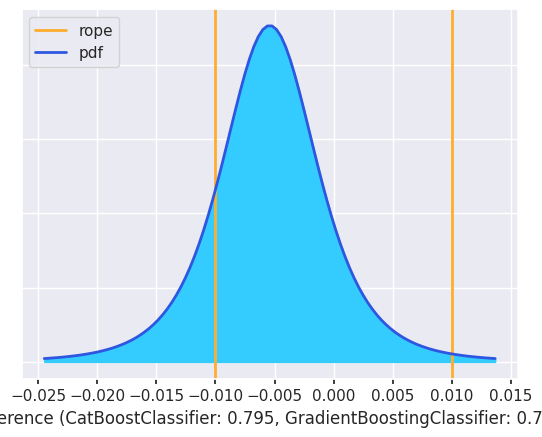

Comparación bayesiana entre CatBoostClassifier y SVC en accuracy: (0.42231220732956465, 0.5597919827900781, 0.017895809880357216)


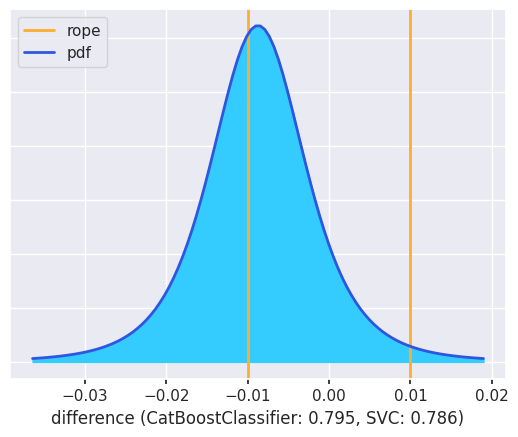

Comparación bayesiana entre CatBoostClassifier y LogisticRegression en accuracy: (0.6321529949055842, 0.3614000341996657, 0.006446970894750104)


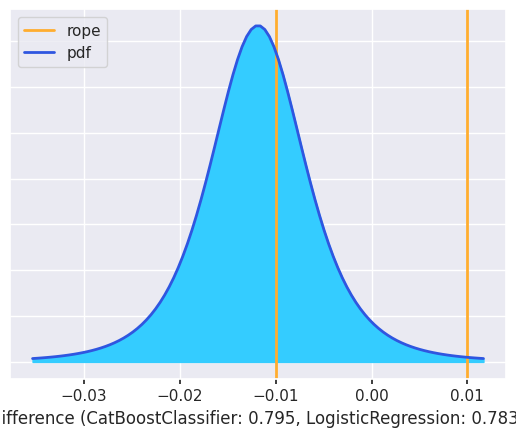

Comparación bayesiana entre RandomForestClassifier y GradientBoostingClassifier en accuracy: (0.008013878151246198, 0.9682583010661636, 0.02372782078259017)


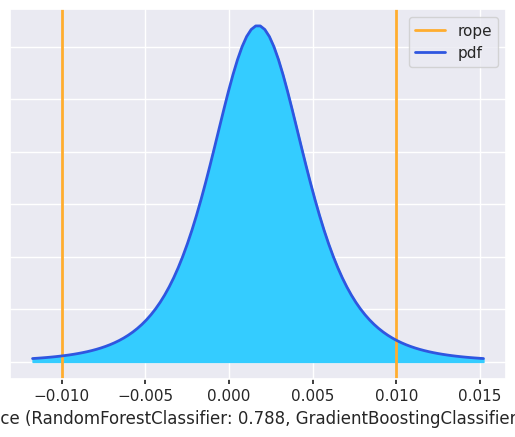

Comparación bayesiana entre RandomForestClassifier y SVC en accuracy: (0.060257945157855396, 0.9133131406919863, 0.026428914150158245)


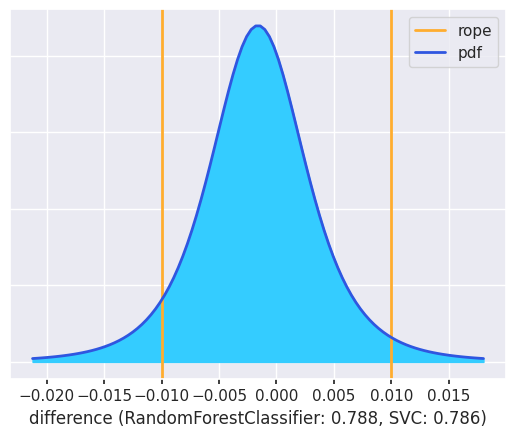

Comparación bayesiana entre RandomForestClassifier y LogisticRegression en accuracy: (0.20007898971648802, 0.7705556102487745, 0.02936540003473742)


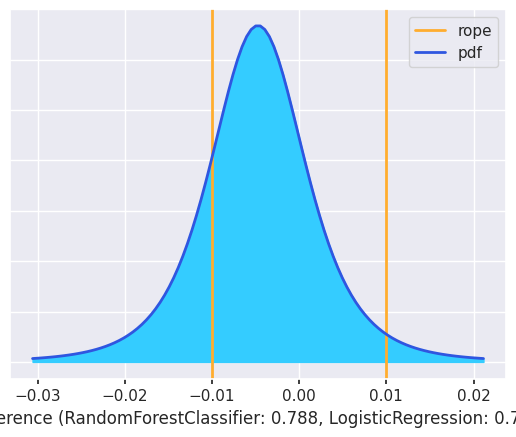

Comparación bayesiana entre GradientBoostingClassifier y SVC en accuracy: (0.1471349963444284, 0.816221789842122, 0.03664321381344959)


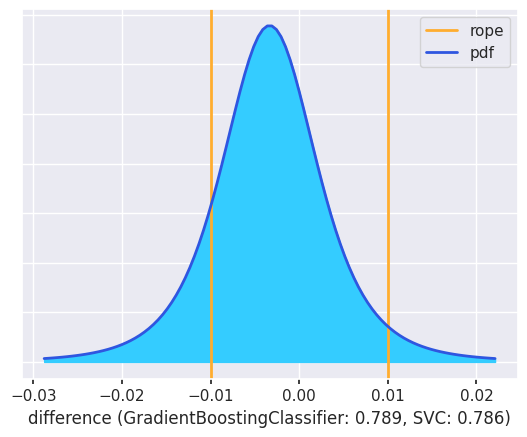

Comparación bayesiana entre GradientBoostingClassifier y LogisticRegression en accuracy: (0.32584407874470317, 0.6304668549770114, 0.04368906627828539)


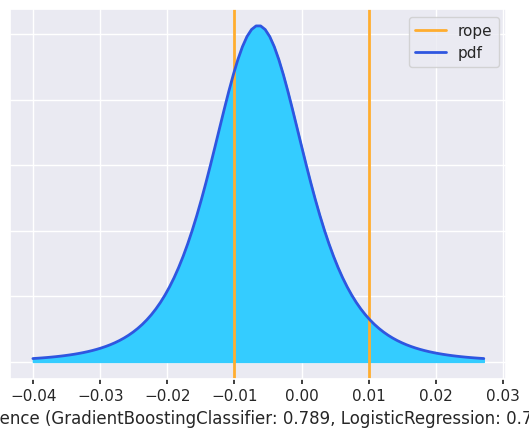

Comparación bayesiana entre SVC y LogisticRegression en accuracy: (0.2516134223206486, 0.6310140014622434, 0.11737257621710806)


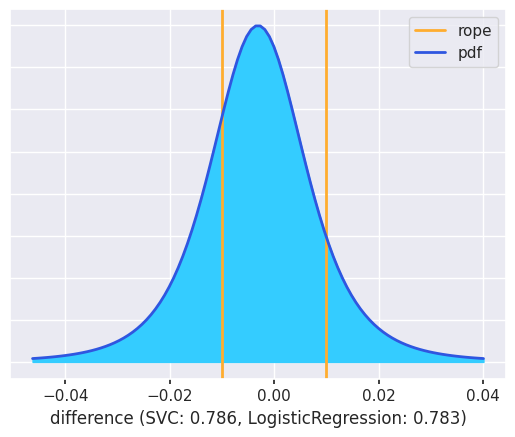

Comparación bayesiana entre CatBoostClassifier y RandomForestClassifier en precision: (0.3086602905374961, 0.688688516655092, 0.002651192807411884)


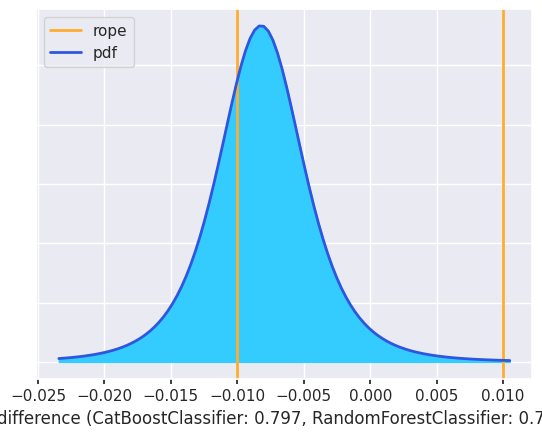

Comparación bayesiana entre CatBoostClassifier y GradientBoostingClassifier en precision: (0.10788937397713233, 0.8743719225757639, 0.01773870344710382)


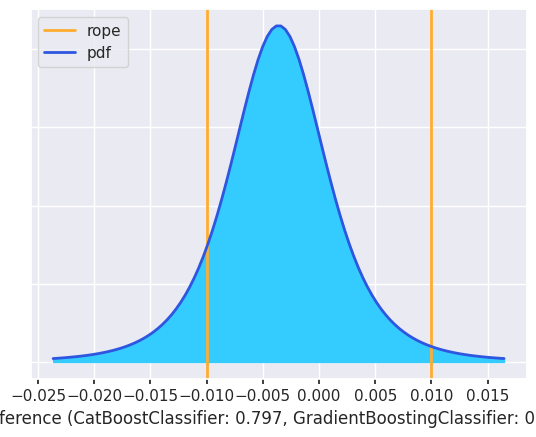

Comparación bayesiana entre CatBoostClassifier y SVC en precision: (0.04553932593039933, 0.9170509941006599, 0.037409679968940734)


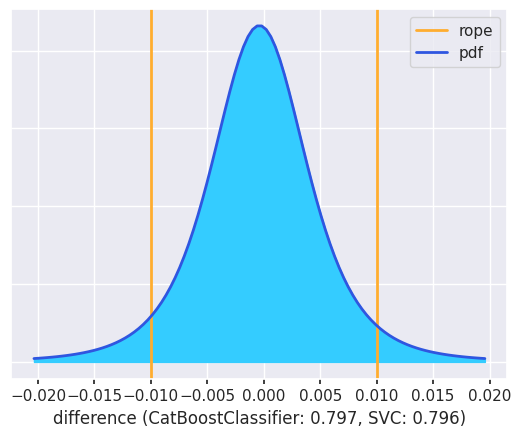

Comparación bayesiana entre CatBoostClassifier y LogisticRegression en precision: (0.6778413945502191, 0.3171315005846147, 0.005027104865166221)


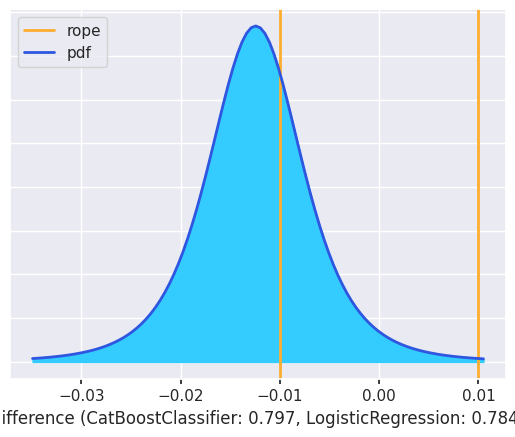

Comparación bayesiana entre RandomForestClassifier y GradientBoostingClassifier en precision: (0.028324575515988284, 0.7802403115146557, 0.191435112969356)


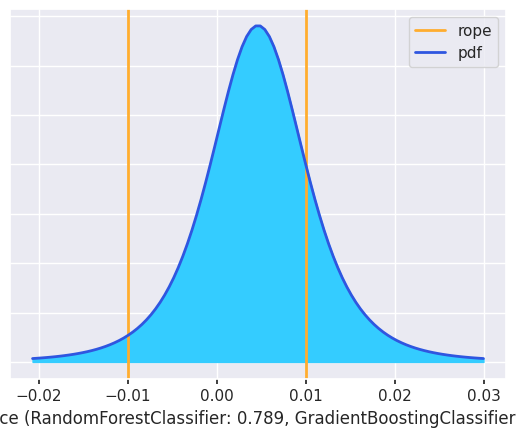

Comparación bayesiana entre RandomForestClassifier y SVC en precision: (0.020726503238952122, 0.6113601523135546, 0.36791334444749335)


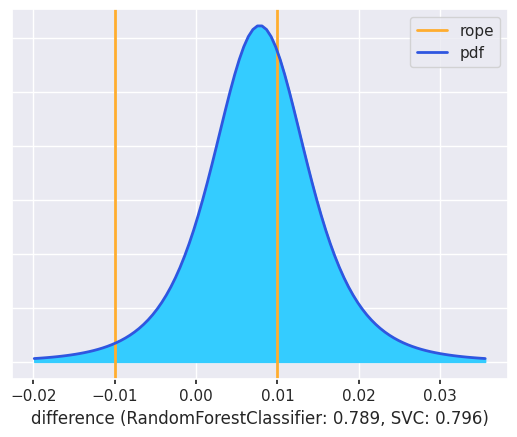

Comparación bayesiana entre RandomForestClassifier y LogisticRegression en precision: (0.22462748612839928, 0.7212553834718023, 0.054117130399798485)


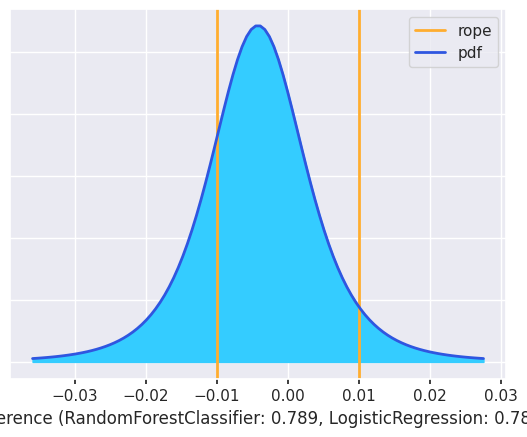

Comparación bayesiana entre GradientBoostingClassifier y SVC en precision: (0.015551156564846205, 0.8997854719757793, 0.08466337145937453)


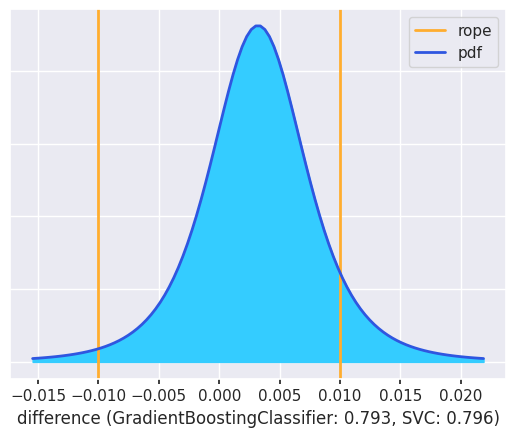

Comparación bayesiana entre GradientBoostingClassifier y LogisticRegression en precision: (0.4393899580372081, 0.531258647471763, 0.02935139449102897)


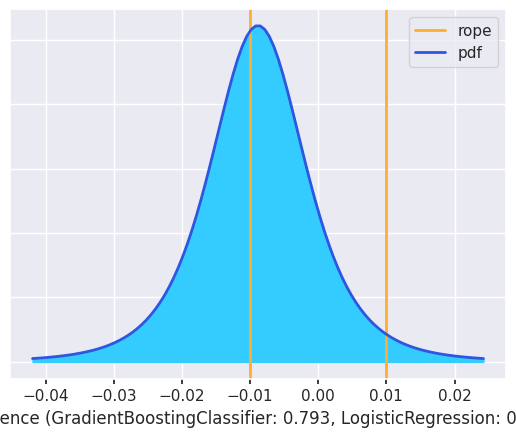

Comparación bayesiana entre SVC y LogisticRegression en precision: (0.5988857131213735, 0.3787352926994998, 0.0223789941791267)


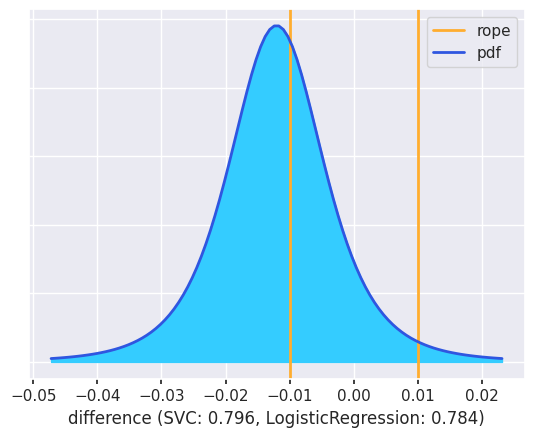

Comparación bayesiana entre CatBoostClassifier y RandomForestClassifier en recall: (0.25246095389396034, 0.741554875717509, 0.0059841703885306075)


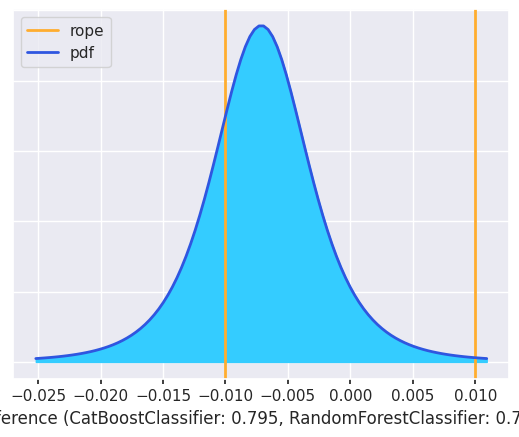

Comparación bayesiana entre CatBoostClassifier y GradientBoostingClassifier en recall: (0.16476045202272702, 0.8249947391778114, 0.010244808799461547)


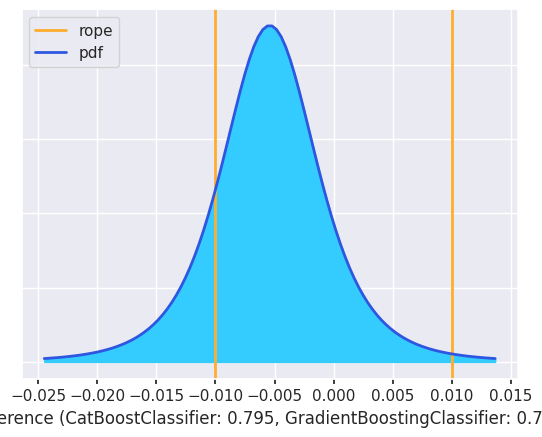

Comparación bayesiana entre CatBoostClassifier y SVC en recall: (0.42231220732956465, 0.5597919827900781, 0.017895809880357216)


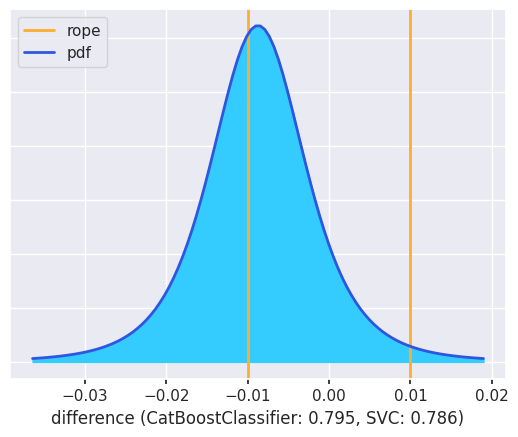

Comparación bayesiana entre CatBoostClassifier y LogisticRegression en recall: (0.6321529949055842, 0.3614000341996657, 0.006446970894750104)


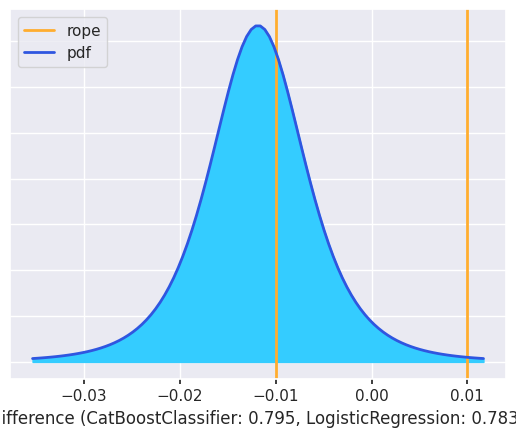

Comparación bayesiana entre RandomForestClassifier y GradientBoostingClassifier en recall: (0.004888143179843166, 0.9797141230908999, 0.015397733729256902)


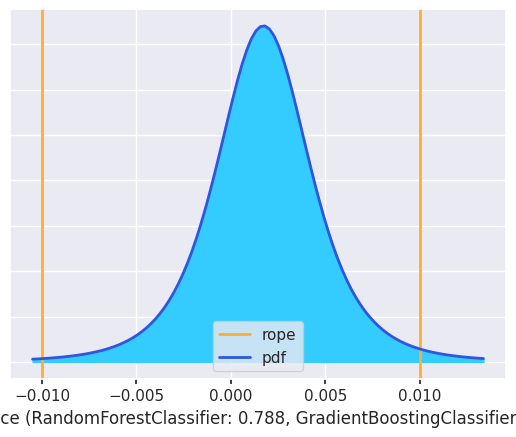

Comparación bayesiana entre RandomForestClassifier y SVC en recall: (0.16272935145093176, 0.739183217465421, 0.09808743108364715)


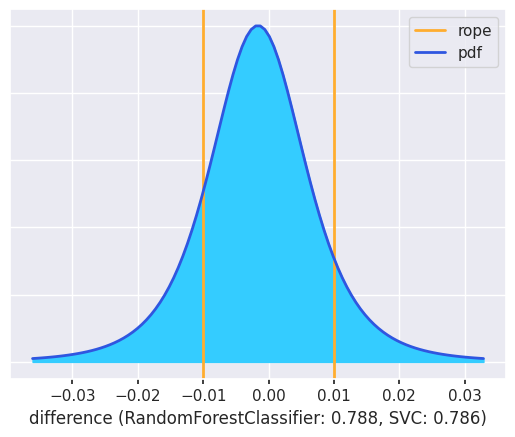

Comparación bayesiana entre RandomForestClassifier y LogisticRegression en recall: (0.21266971748690983, 0.7528881031902672, 0.0344421793228229)


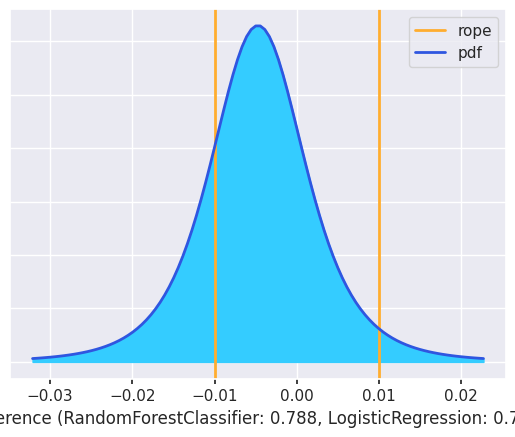

Comparación bayesiana entre GradientBoostingClassifier y SVC en recall: (0.1471349963444284, 0.816221789842122, 0.03664321381344959)


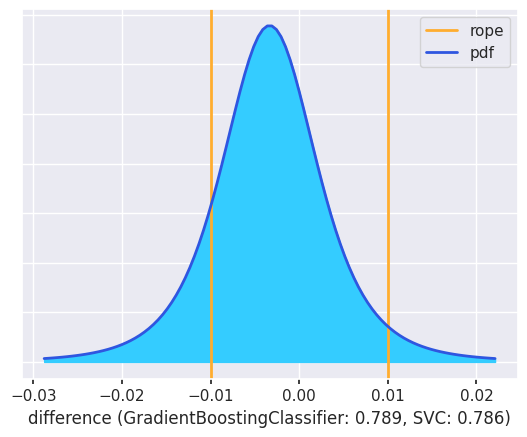

Comparación bayesiana entre GradientBoostingClassifier y LogisticRegression en recall: (0.32584407874470317, 0.6304668549770114, 0.04368906627828539)


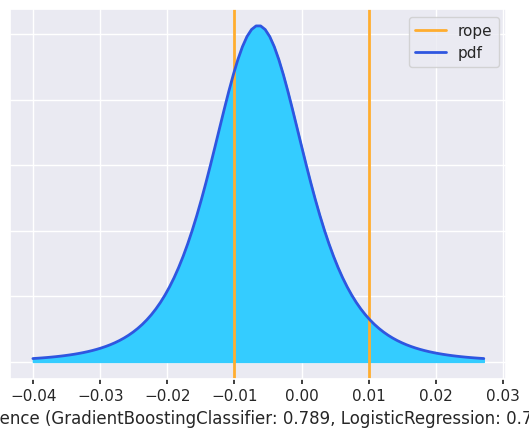

Comparación bayesiana entre SVC y LogisticRegression en recall: (0.2516134223206486, 0.6310140014622434, 0.11737257621710806)


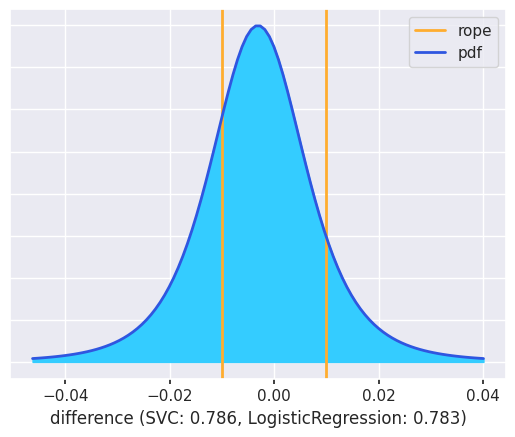

Comparación bayesiana entre CatBoostClassifier y RandomForestClassifier en f1: (0.6313181393870515, 0.3680789514045565, 0.0006029092083920107)


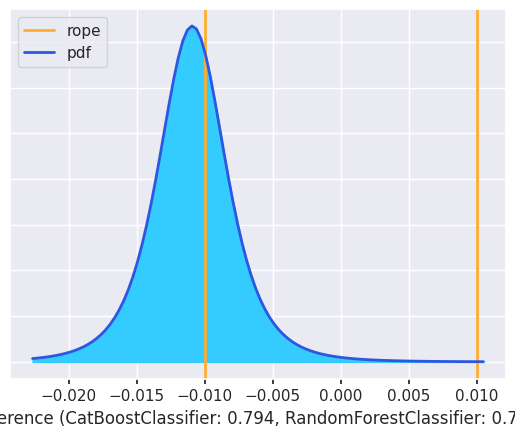

Comparación bayesiana entre CatBoostClassifier y GradientBoostingClassifier en f1: (0.18379454764563347, 0.8066300549632017, 0.009575397391164753)


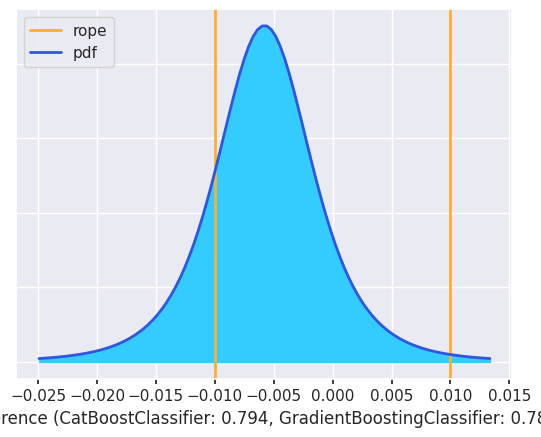

Comparación bayesiana entre CatBoostClassifier y SVC en f1: (0.5263157488668679, 0.4557019948276553, 0.017982256305476785)


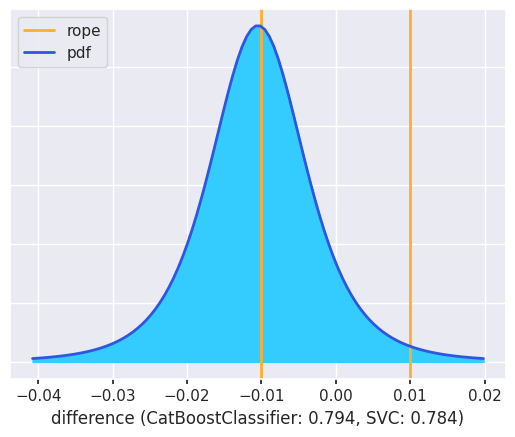

Comparación bayesiana entre CatBoostClassifier y LogisticRegression en f1: (0.62390151058092, 0.3693194677455349, 0.006779021673545049)


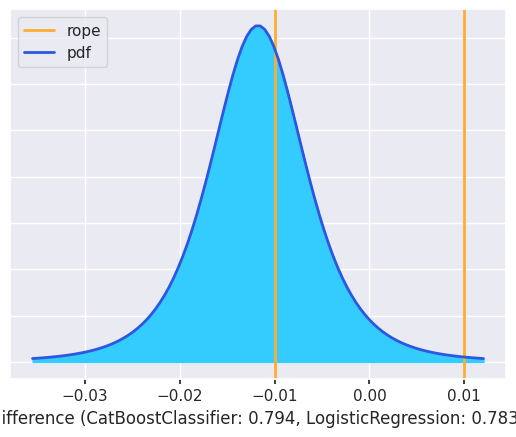

Comparación bayesiana entre RandomForestClassifier y GradientBoostingClassifier en f1: (0.021125613153937173, 0.7800253303801093, 0.19884905646595352)


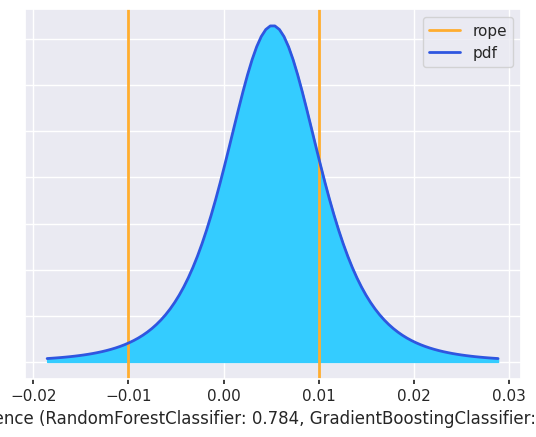

Comparación bayesiana entre RandomForestClassifier y SVC en f1: (0.13925550923486407, 0.7025002202991314, 0.15824427046600453)


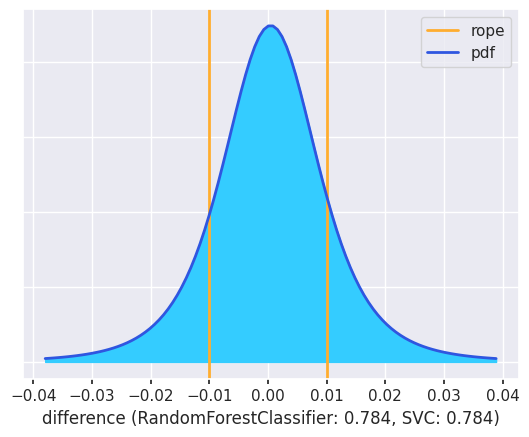

Comparación bayesiana entre RandomForestClassifier y LogisticRegression en f1: (0.017506444351457717, 0.9720908010435716, 0.010402754604970643)


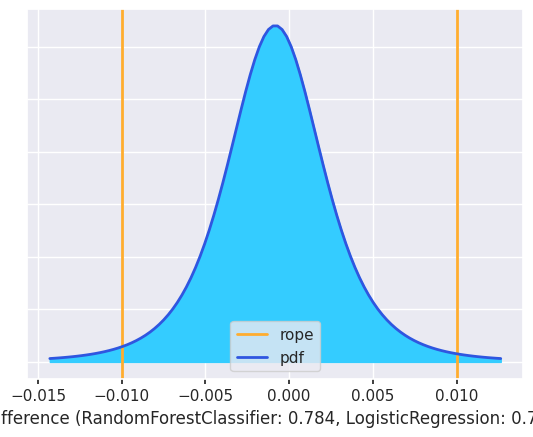

Comparación bayesiana entre GradientBoostingClassifier y SVC en f1: (0.20922866200909282, 0.7569192594943975, 0.03385207849650962)


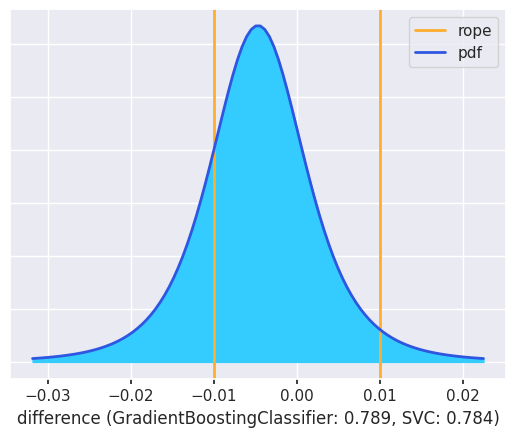

Comparación bayesiana entre GradientBoostingClassifier y LogisticRegression en f1: (0.30673665648695336, 0.645006277331805, 0.04825706618124159)


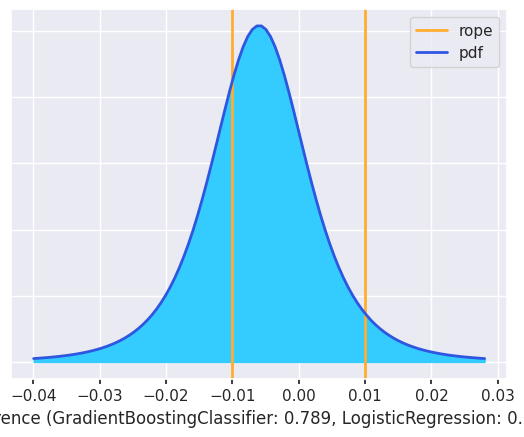

Comparación bayesiana entre SVC y LogisticRegression en f1: (0.21454726131100554, 0.6260654978315262, 0.15938724085746825)


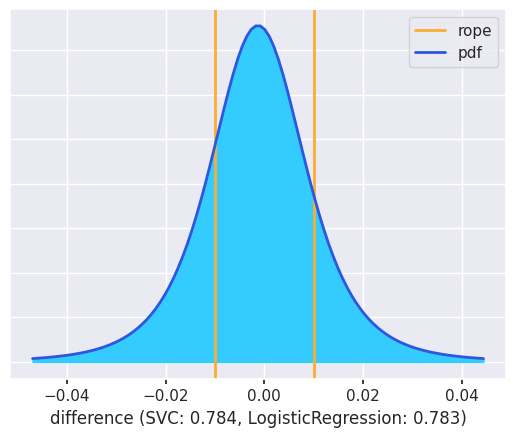

In [ ]:
# Función para realizar comparaciones bayesianas entre todos los pares de modelos y generar gráficos
def comparaciones_bayesianas(df, nombre_metrica):
    rope = 0.01  # Región de Equivalencia Práctica (ROPE)
    bayes_comparison_results = {}

    # Comparar todos los pares únicos de modelos
    for i, modelo_1 in enumerate(df.columns):
        for j, modelo_2 in enumerate(df.columns):
            if i < j:  # Evitar comparaciones duplicadas y autocomparaciones
                # Realizar la comparación bayesiana entre los dos modelos seleccionados usando two_on_single
                probs, fig = baycomp.two_on_single(
                    df[modelo_1].values,  # Resultados del primer modelo
                    df[modelo_2].values,  # Resultados del segundo modelo
                    rope=rope,
                    plot=True,  # Generar el gráfico
                    names=(modelo_1, modelo_2)  # Nombres para los modelos
                )
                bayes_comparison_results[(modelo_1, modelo_2)] = probs
                # Imprimir los resultados
                print(f"Comparación bayesiana entre {modelo_1} y {modelo_2} en {nombre_metrica}: {probs}")

                # Guardar el gráfico
                fig.savefig(f"Comparacion_Bayesiana_{modelo_1}_vs_{modelo_2}_{nombre_metrica}.png")
                plt.show()

    return bayes_comparison_results

# Realizar comparaciones bayesianas para cada métrica y generar los gráficos
resultados_bayesianos_mse = comparaciones_bayesianas(accuracy_df, 'accuracy')
resultados_bayesianos_mae = comparaciones_bayesianas(precision_df, 'precision')
resultados_bayesianos_r2 = comparaciones_bayesianas(recall_df, 'recall')
resultados_bayesianos_rmse = comparaciones_bayesianas(f1_df, 'f1')